In [1]:
# Import necessary libraries for data processing, modeling, and visualization
import itertools
import numpy as np
import pandas as pd
import re
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from bert_score import score
from rapidfuzz import fuzz
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import ClassifierMixin
from typing import List
from bert_score import score
import yake

from text_preparation_utils import sanitize_text, drop_similar_rows
from database_utils import assign_keywords

# Set pandas display options
pd.set_option('display.max_colwidth', 200)  # Increase column width if needed

In [2]:
df = pd.read_csv('bbc_news_text_complexity_summarization.csv')

# Prepare dataset

In [4]:
df['text'] = df['text'].apply(lambda x: sanitize_text(x))
df.head()

,text,labels,no_sentences,Flesch Reading Ease Score,Dale-Chall Readability Score,text_rank_summary,lsa_summary
0,"Ad sales boost Time Warner profitQuarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.The firm, which is now one o...",business,26,62.17,9.72,It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign up AOL's existing customers for high-speed broadband. But its film divisi...,"Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL. Time Warner said on Friday that it now owns 8% of search-engine Google. For the full-year..."
1,Dollar gains on Greenspan speechThe dollar has hit its highest level against the euro in almost three months after the Federal Reserve head said the US trade deficit is set to stabilise.And Alan G...,business,17,65.56,9.09,"The dollar has hit its highest level against the euro in almost three months after the Federal Reserve head said the US trade deficit is set to stabilise. In the meantime, the US Federal Reserve's...","""I think the chairman's taking a much more sanguine view on the current account deficit than he's taken for some time,"" said Robert Sinche, head of currency strategy at Bank of America in New York..."
2,Yukos unit buyer faces loan claimThe owners of embattled Russian oil giant Yukos are to ask the buyer of its former production unit to pay back a $900m (£479m) loan.State-owned Rosneft bought the ...,business,14,69.21,9.66,"The owners of embattled Russian oil giant Yukos are to ask the buyer of its former production unit to pay back a $900m (£479m) loan. ""The pledged assets are with Rosneft, so it will have to pay re...",Yukos' owner Menatep Group says it will ask Rosneft to repay a loan that Yugansk had secured on its assets. Legal experts said Rosneft's purchase of Yugansk would include such obligations. Yukos c...
3,"High fuel prices hit BA's profitsBritish Airways has blamed high fuel prices for a 40% drop in profits.Reporting its results for the three months to 31 December 2004, the airline made a pre-tax pr...",business,24,62.98,9.86,"Looking ahead to its full year results to March 2005, BA warned that yields - average revenues per passenger - were expected to decline as it continues to lower prices in the face of competition f...","Rod Eddington, BA's chief executive, said the results were ""respectable"" in a third quarter when fuel costs rose by £106m or 47.3%. BA's profits were still better than market expectation of £59m, ..."
4,Pernod takeover talk lifts DomecqShares in UK drinks and food firm Allied Domecq have risen on speculation that it could be the target of a takeover by France's Pernod Ricard.Reports in the Wall S...,business,17,70.63,10.23,"Reports in the Wall Street Journal and the Financial Times suggested that the French spirits firm is considering a bid, but has yet to contact its target. Pernod's last major purchase was a third ...",Shares in UK drinks and food firm Allied Domecq have risen on speculation that it could be the target of a takeover by France's Pernod Ricard. Pernod said it was seeking acquisitions but refused t...


In [5]:
print(f"Before deletion of similar texts {len(df)}")
df = drop_similar_rows(df, 'text', 98)
print(f"After the deletion of similar texts {len(df)}")

Before deletion of similar texts 2127
After the deletion of similar texts 2013


# Extract keywords to enrich the database metadata

In [7]:
df['keywords'] = df['text'].apply(lambda x:  assign_keywords(x))

# Decide which summary is best and add it to database

In [9]:
def calculate_bertscore_batch(original_texts: List[str], summaries: List[str]) -> List[float]:
    """
    Calculates the BERTScore for a batch of original texts and their corresponding summaries.

    Args:
        original_texts (List[str]): A list of original texts.
        summaries (List[str]): A list of summaries to evaluate.

    Returns:
        List[float]: A list of F1 scores for the summaries.
    """
    P, R, F1 = score(summaries, original_texts, lang="en", model_type="distilbert-base-uncased", verbose=False)
    return F1.tolist()

def process_batches(df: pd.DataFrame, batch_size: int = 50) -> pd.DataFrame:
    """
    Processes the DataFrame in batches to calculate BERT scores for TextRank and LSA summaries.

    Args:
        df (pd.DataFrame): The DataFrame containing original texts and summaries.
        batch_size (int): The size of each batch for processing.

    Returns:
        pd.DataFrame: The DataFrame with added BERT scores for TextRank and LSA summaries.
    """
    F1_scores_text_rank = []
    F1_scores_lsa = []

    for i in range(0, len(df), batch_size):
        print(f"Processing batch starting at index: {i}")
        batch = df.iloc[i:i + batch_size]
        
        # Calculate BERT scores for TextRank and LSA summaries
        F1_scores_text_rank.extend(calculate_bertscore_batch(batch['text'].tolist(), batch['text_rank_summary'].tolist()))
        F1_scores_lsa.extend(calculate_bertscore_batch(batch['text'].tolist(), batch['lsa_summary'].tolist()))

    df['BERTScore_TextRank'] = F1_scores_text_rank
    df['BERTScore_LSA'] = F1_scores_lsa
    return df

df = process_batches(df)

Processing batch starting at index: 0
Processing batch starting at index: 50
Processing batch starting at index: 100
Processing batch starting at index: 150
Processing batch starting at index: 200
Processing batch starting at index: 250
Processing batch starting at index: 300
Processing batch starting at index: 350
Processing batch starting at index: 400
Processing batch starting at index: 450
Processing batch starting at index: 500
Processing batch starting at index: 550
Processing batch starting at index: 600
Processing batch starting at index: 650
Processing batch starting at index: 700
Processing batch starting at index: 750
Processing batch starting at index: 800
Processing batch starting at index: 850
Processing batch starting at index: 900
Processing batch starting at index: 950
Processing batch starting at index: 1000
Processing batch starting at index: 1050
Processing batch starting at index: 1100
Processing batch starting at index: 1150
Processing batch starting at index: 120

In [10]:
def choose_better_summary(row: pd.Series) -> str:
    """
    Determines the better summary based on BERT scores.

    Args: 
    row (pd.Series): A row from the DataFrame containing BERT scores.

    Returns:
    str: 'TextRank' if TextRank score is higher, 'LSA' if LSA score is higher, 
         or 'Tie' if both scores are equal.
    """
    bert_score_text_rank = row['BERTScore_TextRank']
    bert_score_lsa = row['BERTScore_LSA']
    
    if bert_score_text_rank > bert_score_lsa:
        return 'TextRank'
    elif bert_score_lsa > bert_score_text_rank:
        return 'LSA'
    return 'Tie'

df['Better_Summary'] = df.apply(choose_better_summary, axis=1)

df.head()

,text,labels,no_sentences,Flesch Reading Ease Score,Dale-Chall Readability Score,text_rank_summary,lsa_summary,keywords,BERTScore_TextRank,BERTScore_LSA,Better_Summary
0,"Ad sales boost Time Warner profitQuarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.The firm, which is now one o...",business,26,62.17,9.72,It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign up AOL's existing customers for high-speed broadband. But its film divisi...,"Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL. Time Warner said on Friday that it now owns 8% of search-engine Google. For the full-year...","[Time Warner, boost Time, media giant, AOL, sales boost]",0.822066,0.838018,LSA
1,Dollar gains on Greenspan speechThe dollar has hit its highest level against the euro in almost three months after the Federal Reserve head said the US trade deficit is set to stabilise.And Alan G...,business,17,65.56,9.09,"The dollar has hit its highest level against the euro in almost three months after the Federal Reserve head said the US trade deficit is set to stabilise. In the meantime, the US Federal Reserve's...","""I think the chairman's taking a much more sanguine view on the current account deficit than he's taken for some time,"" said Robert Sinche, head of currency strategy at Bank of America in New York...","[Alan Greenspan, Federal Reserve, Greenspan highlighted, highest level, Dollar]",0.851845,0.851041,TextRank
2,Yukos unit buyer faces loan claimThe owners of embattled Russian oil giant Yukos are to ask the buyer of its former production unit to pay back a $900m (£479m) loan.State-owned Rosneft bought the ...,business,14,69.21,9.66,"The owners of embattled Russian oil giant Yukos are to ask the buyer of its former production unit to pay back a $900m (£479m) loan. ""The pledged assets are with Rosneft, so it will have to pay re...",Yukos' owner Menatep Group says it will ask Rosneft to repay a loan that Yugansk had secured on its assets. Legal experts said Rosneft's purchase of Yugansk would include such obligations. Yukos c...,"[embattled Russian, Russian oil, unit buyer, part settle, Yukos]",0.881917,0.863560,TextRank
3,"High fuel prices hit BA's profitsBritish Airways has blamed high fuel prices for a 40% drop in profits.Reporting its results for the three months to 31 December 2004, the airline made a pre-tax pr...",business,24,62.98,9.86,"Looking ahead to its full year results to March 2005, BA warned that yields - average revenues per passenger - were expected to decline as it continues to lower prices in the face of competition f...","Rod Eddington, BA's chief executive, said the results were ""respectable"" in a third quarter when fuel costs rose by £106m or 47.3%. BA's profits were still better than market expectation of £59m, ...","[profitsBritish Airways, High fuel, blamed high, fuel prices, December]",0.853448,0.837224,TextRank
4,Pernod takeover talk lifts DomecqShares in UK drinks and food firm Allied Domecq have risen on speculation that it could be the target of a takeover by France's Pernod Ricard.Reports in the Wall S...,business,17,70.63,10.23,"Reports in the Wall Street Journal and the Financial Times suggested that the French spirits firm is considering a bid, but has yet to contact its target. Pernod's last major purchase was a third ...",Shares in UK drinks and food firm Allied Domecq have risen on speculation that it could be the target of a takeover by France's Pernod Ricard. Pernod said it was seeking acquisitions but refused t...,"[Wall Street, Street Journal, lifts DomecqShares, Pernod takeover, France]",0.857391,0.834362,TextRank


In [11]:
df['Better_Summary'].value_counts()

Better_Summary
TextRank    1573
LSA          438
Tie            2
Name: count, dtype: int64

In [12]:
df['summary'] = df.apply(
    lambda row: row['lsa_summary'] if row['Better_Summary'] == 'LSA' else row['text_rank_summary'], 
    axis=1  
)
df = df.drop(columns = ['lsa_summary', 'text_rank_summary', 'BERTScore_TextRank', 'BERTScore_LSA', 'Better_Summary'])

# Make model to classify categories

<Axes: xlabel='labels', ylabel='count'>

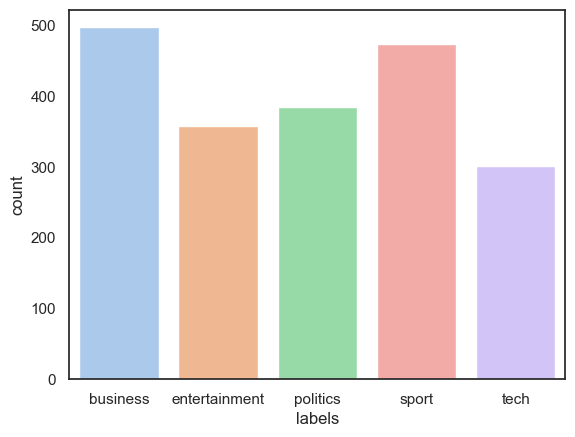

In [14]:
sns.set_theme(style="white", palette="pastel")
sns.countplot(x="labels", hue = "labels", data=df)

In [15]:
label_encoder = LabelEncoder()
df['category_encoded'] = label_encoder.fit_transform(df['labels'])

In [16]:
df.head()

,text,labels,no_sentences,Flesch Reading Ease Score,Dale-Chall Readability Score,keywords,summary,category_encoded
0,"Ad sales boost Time Warner profitQuarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.The firm, which is now one o...",business,26,62.17,9.72,"[Time Warner, boost Time, media giant, AOL, sales boost]","Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL. Time Warner said on Friday that it now owns 8% of search-engine Google. For the full-year...",0
1,Dollar gains on Greenspan speechThe dollar has hit its highest level against the euro in almost three months after the Federal Reserve head said the US trade deficit is set to stabilise.And Alan G...,business,17,65.56,9.09,"[Alan Greenspan, Federal Reserve, Greenspan highlighted, highest level, Dollar]","The dollar has hit its highest level against the euro in almost three months after the Federal Reserve head said the US trade deficit is set to stabilise. In the meantime, the US Federal Reserve's...",0
2,Yukos unit buyer faces loan claimThe owners of embattled Russian oil giant Yukos are to ask the buyer of its former production unit to pay back a $900m (£479m) loan.State-owned Rosneft bought the ...,business,14,69.21,9.66,"[embattled Russian, Russian oil, unit buyer, part settle, Yukos]","The owners of embattled Russian oil giant Yukos are to ask the buyer of its former production unit to pay back a $900m (£479m) loan. ""The pledged assets are with Rosneft, so it will have to pay re...",0
3,"High fuel prices hit BA's profitsBritish Airways has blamed high fuel prices for a 40% drop in profits.Reporting its results for the three months to 31 December 2004, the airline made a pre-tax pr...",business,24,62.98,9.86,"[profitsBritish Airways, High fuel, blamed high, fuel prices, December]","Looking ahead to its full year results to March 2005, BA warned that yields - average revenues per passenger - were expected to decline as it continues to lower prices in the face of competition f...",0
4,Pernod takeover talk lifts DomecqShares in UK drinks and food firm Allied Domecq have risen on speculation that it could be the target of a takeover by France's Pernod Ricard.Reports in the Wall S...,business,17,70.63,10.23,"[Wall Street, Street Journal, lifts DomecqShares, Pernod takeover, France]","Reports in the Wall Street Journal and the Financial Times suggested that the French spirits firm is considering a bid, but has yet to contact its target. Pernod's last major purchase was a third ...",0


# Prepare the training and test set for text classification

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df['text'],
                                                    df['category_encoded'],
                                                    test_size=0.2,
                                                    random_state=0, 
                                                    stratify = df['category_encoded']
                                                    )

In [19]:
vectorizer = TfidfVectorizer(stop_words='english',
                             ngram_range=(1,3),
                             min_df=5,
                             strip_accents='unicode')
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)
X_train_vectorized

<1610x10594 sparse matrix of type '<class 'numpy.float64'>'
	with 228313 stored elements in Compressed Sparse Row format>

In [20]:
def plot_confusion_matrix(cm: np.ndarray,
                          classes: list,
                          title: str = 'Confusion matrix',
                          cmap: plt.cm = plt.cm.Blues) -> None:
    """
    Plots a confusion matrix using matplotlib.

    Args:
        cm (np.ndarray): Confusion matrix to be plotted.
        classes (list): List of class names corresponding to the confusion matrix.
        title (str, optional): Title of the plot. Defaults to 'Confusion matrix'.
        cmap (plt.cm, optional): Colormap to be used for the plot. Defaults to plt.cm.Blues.

    Returns:
        None: This function does not return a value; it displays a plot.
    """
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm_normalized, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    threshold = cm_normalized.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm_normalized[i, j] > threshold else "black"
        plt.text(j, i, f"{cm_normalized[i, j]:.2f}", horizontalalignment="center", color=color)

    plt.ylabel('True values')
    plt.xlabel('Predicted values')
    plt.tight_layout()

# Train the models

              precision    recall  f1-score   support

           0     0.9412    0.9600    0.9505       100
           1     1.0000    0.9859    0.9929        71
           2     0.9737    0.9610    0.9673        77
           3     0.9896    1.0000    0.9948        95
           4     0.9661    0.9500    0.9580        60

    accuracy                         0.9727       403
   macro avg     0.9741    0.9714    0.9727       403
weighted avg     0.9729    0.9727    0.9727       403



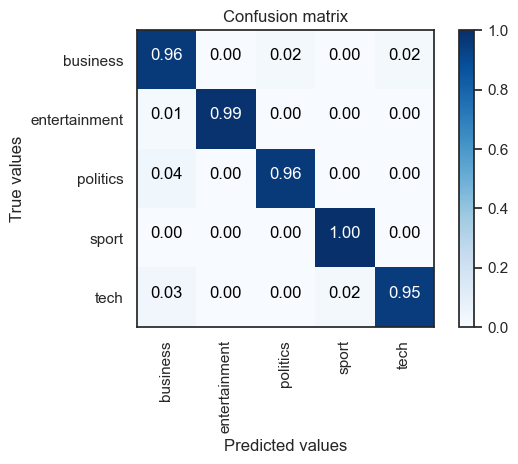

In [22]:
def train_and_evaluate_classifier(model: ClassifierMixin, X_train: np.ndarray, y_train: np.ndarray, 
                                   X_test: np.ndarray, y_test: np.ndarray, 
                                   label_encoder) -> None:
    """
    Trains a specified classifier and evaluates its performance.

    Args:
    model (ClassifierMixin): An instance of a classifier that follows the scikit-learn interface.
    X_train (np.ndarray): The training feature set.
    y_train (np.ndarray): The training labels.
    X_test (np.ndarray): The test feature set.
    y_test (np.ndarray): The test labels.
    label_encoder: The label encoder used to decode the labels for the confusion matrix.

    Returns:
    None: This function prints the classification report and plots the confusion matrix.
    """
    # Train a multi-output classifier
    clf.fit(X_train, y_train)

    # Make predictions
    y_pred = clf.predict(X_test)

    # Print classification report
    print(classification_report(y_test, y_pred, digits=4))

    # Compute and plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, label_encoder.classes_)


#MultinomialNB is a probabilistic classifier based on Bayes' theorem, specifically designed for discrete features, 
#commonly used for text classification tasks where the features represent word counts or frequencies

clf = MultinomialNB()
train_and_evaluate_classifier(clf, X_train_vectorized, y_train, X_test_vectorized, y_test, label_encoder)

              precision    recall  f1-score   support

           0     0.9412    0.9600    0.9505       100
           1     1.0000    0.9859    0.9929        71
           2     0.9737    0.9610    0.9673        77
           3     0.9896    1.0000    0.9948        95
           4     0.9661    0.9500    0.9580        60

    accuracy                         0.9727       403
   macro avg     0.9741    0.9714    0.9727       403
weighted avg     0.9729    0.9727    0.9727       403



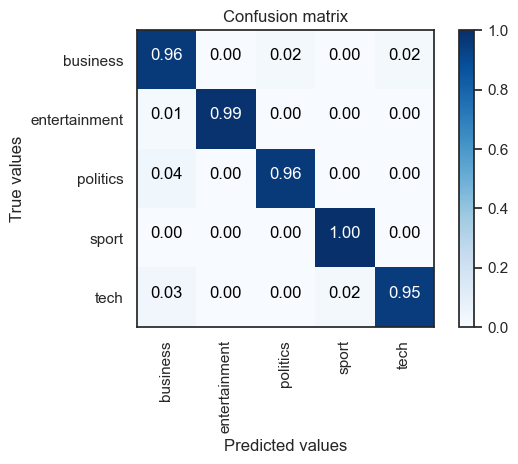

In [23]:
#LogisticRegression is a statistical model that uses a logistic function to model the probability of a binary 
#outcome based on one or more predictor variables, making it suitable for binary classification tasks.

clf_2 = LogisticRegression(max_iter=1000)
train_and_evaluate_classifier(clf_2, X_train_vectorized, y_train, X_test_vectorized, y_test, label_encoder)

              precision    recall  f1-score   support

           0     0.9412    0.9600    0.9505       100
           1     1.0000    0.9859    0.9929        71
           2     0.9737    0.9610    0.9673        77
           3     0.9896    1.0000    0.9948        95
           4     0.9661    0.9500    0.9580        60

    accuracy                         0.9727       403
   macro avg     0.9741    0.9714    0.9727       403
weighted avg     0.9729    0.9727    0.9727       403



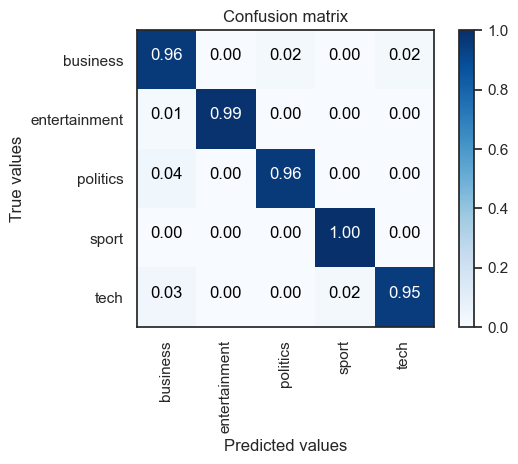

In [41]:
#LinearSVC is a support vector machine classifier that uses a linear kernel to find the optimal hyperplane for
#separating data points in a high-dimensional space, making it efficient for large datasets with a linear decision boundary

clf_3 = LinearSVC()
train_and_evaluate_classifier(clf_3, X_train_vectorized, y_train, X_test_vectorized, y_test, label_encoder)

              precision    recall  f1-score   support

           0     0.9412    0.9600    0.9505       100
           1     1.0000    0.9859    0.9929        71
           2     0.9737    0.9610    0.9673        77
           3     0.9896    1.0000    0.9948        95
           4     0.9661    0.9500    0.9580        60

    accuracy                         0.9727       403
   macro avg     0.9741    0.9714    0.9727       403
weighted avg     0.9729    0.9727    0.9727       403



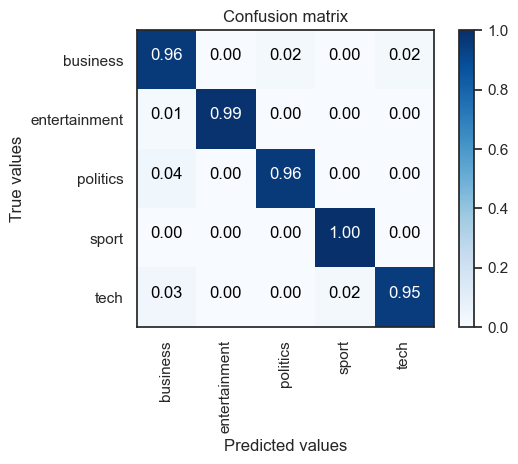

In [43]:
#RandomForestClassifier is an ensemble learning method that constructs multiple decision trees during training and
#outputs the mode of their predictions for classification tasks, providing robustness against overfitting and improved accuracy.

clf_4 = RandomForestClassifier()
train_and_evaluate_classifier(clf_4, X_train_vectorized, y_train, X_test_vectorized, y_test, label_encoder)

# Save models

In [29]:
with open('BBC_articles_vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)

with open('BBC_articles_classifier.pkl', 'wb') as file:
    pickle.dump(clf, file)

with open('BBC_articles_label_encoder.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)

# Save cleaned and prepared dataset

In [30]:
df.to_csv('bbc_news_base.csv')

# Sources

1. https://www.kaggle.com/datasets/jacopoferretti/bbc-articles-dataset
2. https://github.com/Jannixen/Azure-Depression-from-tweets/blob/main/notebooks/depression_detection.ipynb